## Load Data

In [104]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt
import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import datetime as dt

In [88]:
#load data and replace nulls
df = pd.read_csv('../data/Startup Data.csv')
df = df.replace('NaN', np.nan) 

#row 124 and 832 are repeats of the same data point
df.iloc[124] == df.iloc[832]
df = df.drop(832)

In [89]:
#check for unique id columns that can be ignored
print(df['Unnamed: 0'].value_counts().shape == df['Unnamed: 0'].shape)
print(df['id'].value_counts().shape == df['id'].shape)
print(df['name'].value_counts().shape == df['name'].shape)
print(df['object_id'].value_counts().shape == df['object_id'].shape)

#state code is repeated twice with one mismatched state name
print((df['state_code.1'] == df['state_code']).value_counts())

del df['Unnamed: 0']
del df['id']
del df['name']
del df['object_id']
del df['state_code.1']

True
True
True
True
True     921
False      1
dtype: int64


In [125]:
#all remaining features split between categorical/continuous/dates to be transformed to continuous
#categorical features split further between ordinal scaler and one hot encoder

cat_ftrs = ['state_code', 'zip_code', 'city','labels', 'category_code', 'is_CA','is_NY','is_MA', 
        'is_TX', 'is_otherstate', 'category_code', 'is_software', 'is_web','is_mobile', 
        'is_enterprise','is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 
        'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 
        'has_roundB', 'has_roundC', 'has_roundD','is_top500', 'milestones']

ss_ftrs = ['latitude', 'longitude', 'age_first_funding_year', 'age_last_funding_year', 
            'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 
            'funding_rounds', 'avg_participants', 'funding_total_usd',]



In [126]:
#converting all the dates into continuous features, replaced negative times with NaNs
dates = ['founded_at', 'closed_at', 'first_funding_at', 'last_funding_at']
for date in dates:
    df[date] = pd.to_datetime(df[date]).values.astype(np.int64) // 10**6
for i in range(df.shape[0]):
    if df['closed_at'].iloc[i] < 0:
        df['closed_at'].iloc[i] = np.nan

C:\Users\aksha\anaconda3\envs\data1030\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [127]:
cat_ftrs = ['state_code', 'zip_code', 'city','labels', 'category_code', 'is_CA','is_NY','is_MA', 
        'is_TX', 'is_otherstate', 'category_code', 'is_software', 'is_web','is_mobile', 
        'is_enterprise','is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 
        'is_consulting', 'is_othercategory','has_VC', 'has_angel', 'has_roundA', 
        'has_roundB', 'has_roundC', 'has_roundD','is_top500', 'milestones', 'founded_at', 'closed_at', 
        'first_funding_at', 'last_funding_at']

## EDA

state_code 
 CA    487
NY    106
MA     83
TX     42
WA     42
CO     19
IL     18
PA     17
VA     13
GA     11
NC      7
MD      7
NJ      7
OR      7
FL      6
OH      6
MN      5
CT      4
DC      4
TN      3
UT      3
MI      3
RI      3
AZ      2
MO      2
NH      2
IN      2
NV      2
KY      2
ME      2
AR      1
WI      1
NM      1
WV      1
ID      1
Name: state_code, dtype: int64 

count    922.000000
mean      38.518566
std        3.743372
min       25.752358
25%       37.388869
50%       37.779281
75%       40.730646
max       59.335232
Name: latitude, dtype: float64


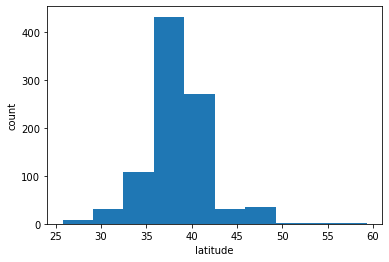

count    922.000000
mean    -103.519249
std       22.398102
min     -122.756956
25%     -122.199823
50%     -118.365504
75%      -77.213612
max       18.057121
Name: longitude, dtype: float64


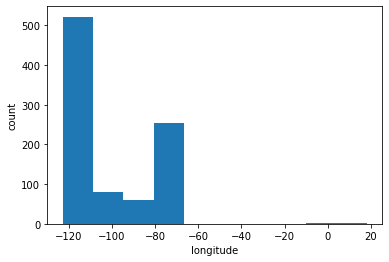

zip_code 
 94107         30
94105         23
95054         20
94103         19
94043         18
              ..
8827           1
1824           1
6032           1
01752-4603     1
2116           1
Name: zip_code, Length: 382, dtype: int64 

city 
 San Francisco    128
New York          91
Mountain View     47
Palo Alto         35
Austin            27
                ... 
Hampton            1
Waco               1
West Newfield      1
Paramus            1
Dulles             1
Name: city, Length: 221, dtype: int64 

labels 
 1    596
0    326
Name: labels, dtype: int64 

founded_at 
 1041379    55
1104537    54
1136073    54
1009843    54
946684     53
           ..
1102291     1
1115596     1
1105747     1
1238457     1
1196035     1
Name: founded_at, Length: 217, dtype: int64 

closed_at 
 1370044.0    25
1325376.0    24
1372636.0    15
1367366.0    12
1293840.0     8
             ..
1297641.0     1
1283299.0     1
1342656.0     1
1363132.0     1
1251331.0     1
Name: closed_at, Length

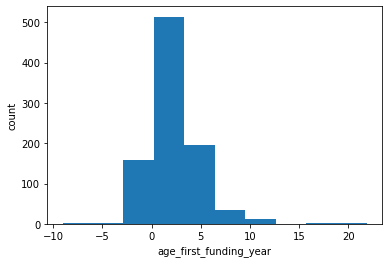

count    922.000000
mean       3.930933
std        2.969478
min       -9.046600
25%        1.669175
50%        3.520550
75%        5.560925
max       21.895900
Name: age_last_funding_year, dtype: float64


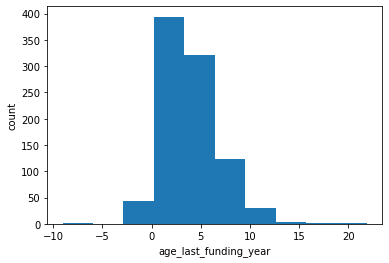

count    770.000000
mean       3.055706
std        2.978976
min      -14.169900
25%        1.000000
50%        2.519150
75%        4.688350
max       24.684900
Name: age_first_milestone_year, dtype: float64


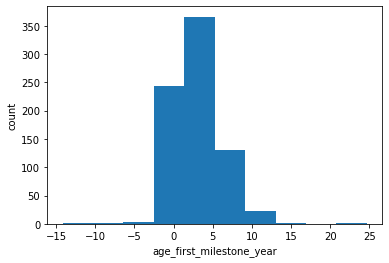

count    770.000000
mean       4.755399
std        3.214081
min       -7.005500
25%        2.397300
50%        4.482200
75%        6.753400
max       24.684900
Name: age_last_milestone_year, dtype: float64


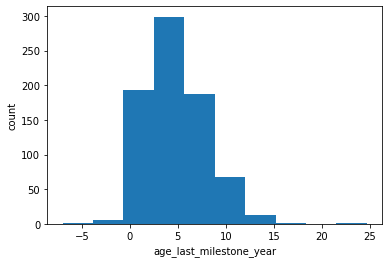

count    922.000000
mean       7.703905
std        7.266762
min        0.000000
25%        3.000000
50%        5.000000
75%       10.000000
max       63.000000
Name: relationships, dtype: float64


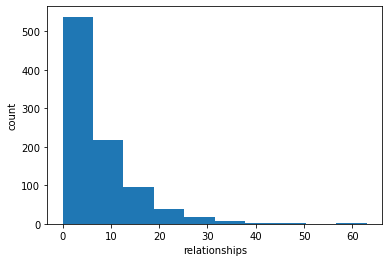

count    922.000000
mean       2.309111
std        1.390562
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       10.000000
Name: funding_rounds, dtype: float64


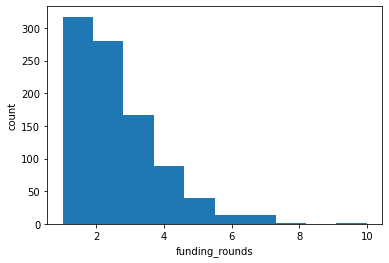

count    9.220000e+02
mean     2.541017e+07
std      1.897371e+08
min      1.100000e+04
25%      2.712500e+06
50%      1.000000e+07
75%      2.465264e+07
max      5.700000e+09
Name: funding_total_usd, dtype: float64


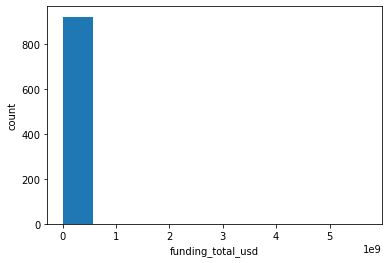

milestones 
 1    250
2    245
3    182
0    152
4     62
5     24
6      6
8      1
Name: milestones, dtype: int64 

is_CA 
 1    486
0    436
Name: is_CA, dtype: int64 

is_NY 
 0    816
1    106
Name: is_NY, dtype: int64 

is_MA 
 0    839
1     83
Name: is_MA, dtype: int64 

is_TX 
 0    880
1     42
Name: is_TX, dtype: int64 

is_otherstate 
 0    718
1    204
Name: is_otherstate, dtype: int64 

category_code 
 software            153
web                 144
mobile               79
enterprise           73
advertising          62
games_video          52
semiconductor        35
network_hosting      34
biotech              34
hardware             27
ecommerce            25
public_relations     25
cleantech            22
analytics            19
security             19
social               14
search               12
other                11
messaging            11
fashion               8
news                  8
travel                8
photo_video           7
medical               7
musi

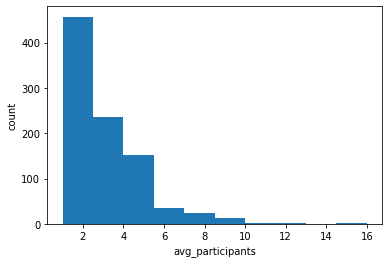

is_top500 
 1    746
0    176
Name: is_top500, dtype: int64 



In [128]:
#histograms/bar charts of all features
columns = df.columns
for col in columns:
    if col in ss_ftrs:
        print(df[col].describe())
        df[col].plot.hist()
        plt.xlabel(col)
        plt.ylabel('count')
        plt.show()
    if col in cat_ftrs:
        print(col, '\n', df[col].value_counts(), '\n')
        

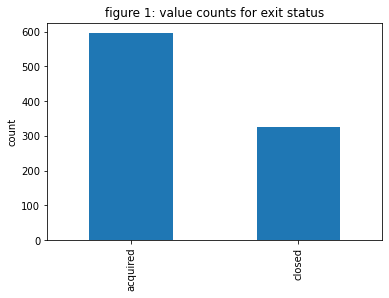

In [144]:
df['status'].value_counts().plot.bar()
plt.ylabel('count')
plt.title('figure 1: value counts for exit status')
plt.show()

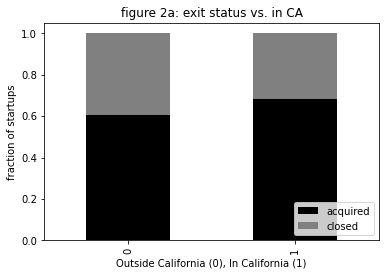

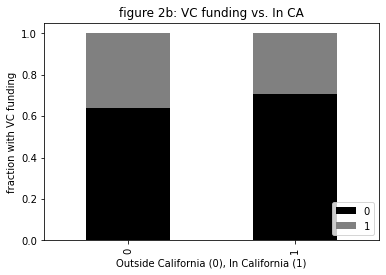

In [147]:
#comparing how well california startups did relative to the rest of the country
count_matrix = df.groupby(['is_CA', 'status']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True, color = ['k', 'grey'])
plt.title('figure 2a: exit status vs. in CA')
plt.xlabel('Outside California (0), In California (1)')
plt.ylabel('fraction of startups')
plt.legend(loc=4)
plt.show()

count_matrix = df.groupby(['is_CA', 'has_VC']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True, color = ['k', 'grey'])
plt.xlabel('Outside California (0), In California (1)')
plt.title('figure 2b: VC funding vs. In CA')
plt.ylabel('fraction with VC funding')
plt.legend(loc=4)
plt.show()

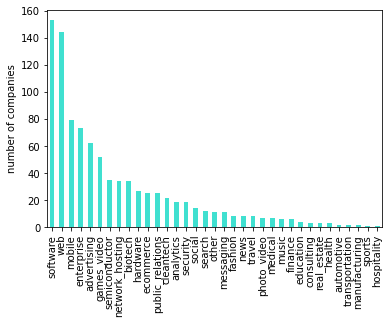

In [131]:
#histogram of the industries
df['category_code'].value_counts().plot.bar(color = 'turquoise')
plt.ylabel('number of companies')
plt.show()

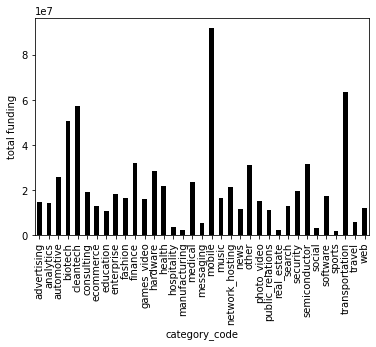

In [132]:
#plot showing industry type against total funding amount in usd
df.groupby('category_code', as_index=True)['funding_total_usd'].mean().plot.bar(color = 'k')
plt.ylabel('total funding')
plt.show()

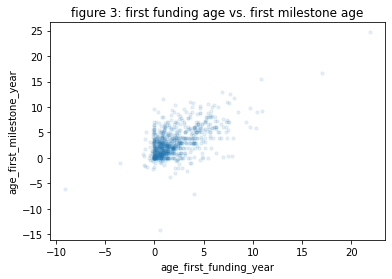

In [148]:
#comparing age of first funding year and age at first milestone shows a high concentration near (0,0)
#it is interesting to note the few outliers that were funded much later in their lives
df.plot.scatter('age_first_funding_year', 'age_first_milestone_year', s=10, alpha=.1)
plt.title('figure 3: first funding age vs. first milestone age')
plt.show()

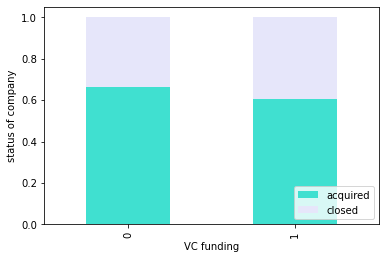

In [134]:
#funding vs status
count_matrix = df.groupby(['has_VC', 'status']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True, color = ['turquoise', 'lavender'])
plt.ylabel('status of company')
plt.xlabel('VC funding')
plt.legend(loc=4)
plt.show()

In [135]:
df.groupby(['has_VC', 'status']).size().unstack()

status,acquired,closed
has_VC,,
0,414,208
1,182,118


## Split Data

In [136]:
#set X and y matrices
y = df['status']
X = df.loc[:, df.columns != 'status']
X = X.fillna(0)

In [137]:
#data split
random_state = 7

#separate out training set
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=random_state)

#split out validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X,y,train_size = 0.5,random_state=random_state)

## Preprocessing

In [138]:
#preprocess the data using one hot encoder and standard scaler

preprocessor = ColumnTransformer(transformers = 
        [('onehot',  OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_ftrs), 
          ('ss', StandardScaler(), ss_ftrs)])

clf = Pipeline(steps = [('preprocessor', preprocessor)])

X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

print(X_train_prep[:5])

[[ 0.          0.          0.         ... -0.9601818   0.07886135
  -0.11928396]
 [ 0.          1.          0.         ... -0.9601818   3.61963765
  -0.11646285]
 [ 0.          1.          0.         ...  2.70681085  1.09051172
   0.09867417]
 [ 0.          0.          0.         ... -0.22678327 -0.93278903
  -0.12035827]
 [ 0.          0.          0.         ... -0.22678327  0.07886135
  -0.11390007]]


In [139]:
#label encoder for target variable
le = LabelEncoder()
y_train_prep = le.fit_transform(y_train)
y_val_prep = le.transform(y_val)
y_test_prep = le.transform(y_test)

In [140]:
X_train_prep.shape

(553, 1720)